# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [1]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

## QC Settings

In [2]:
filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = False  # True or False; select only highly variable features

############################# filters with cutoffs ####################################
# if this is True thresholds below are ignored 
automatic_thresholds = True # True or False; to use automatic thresholds

# if thresholds None they are set automatically
n_features_filter = False # True or False; filtering out cells with numbers of features not in the range defined below
# default values n_features 
min_features = 5
max_features = 10000

mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
# default mean_insertsize
upper_threshold_mis=160 
lower_threshold_mis=80

filter_pct_fp=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default promotor enrichment
upper_threshold_pct_fp=0.4
lower_threshold_pct_fp=0.1

filter_n_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments
upper_thr_fragments=None
lower_thr_fragments=None

filter_chrM_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments in chrM
upper_thr_chrM_fragments=None
lower_thr_chrM_fragments=None

filter_uniquely_mapped_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of uniquely mapped fragments
upper_thr_um=1000000
lower_thr_um=0



## Sum up settings

In [3]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['features'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}
    
plot_cols = list(manual_thresholds.keys())

## Loading packages and setup

In [4]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.plotting_atac import *
from sctoolbox.atac_filter import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [5]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [6]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 373 × 3830
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution'

## hack to visualize nucleosomal signal

In [7]:
#adata.uns['insertsize_distribution'] = adata.uns['insertsize_distribution'].swapaxes('index', 'columns')

In [8]:
#adata.uns['insertsize_distribution']

In [9]:
#atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [10]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [11]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [12]:
display(adata)

View of AnnData object with n_obs × n_vars = 373 × 3830
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution'

## 2. removing empty cells and features

In [13]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 322 × 3746
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution'

## 3. binarize

In [14]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 4. select highly variable genes

In [15]:
if select_hvf:
    select_var_feature(adata, min_score=0.5, nb_features=None, show=False, copy=False)

## 5. visualize adata

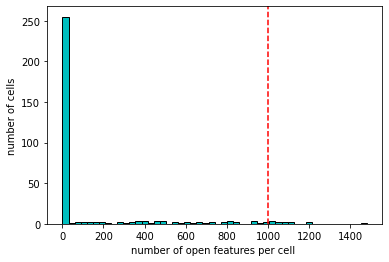

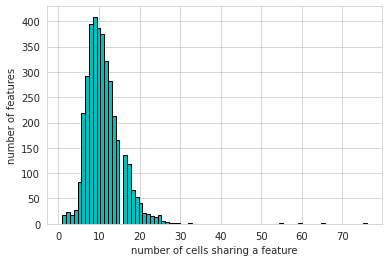

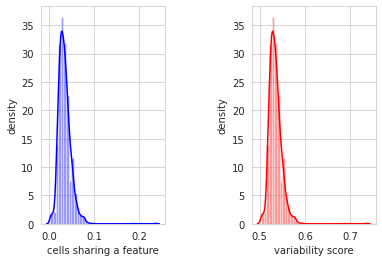

In [16]:
plot_ov_hist(adata, threshold_features=1000)

(<Figure size 576x864 with 6 Axes>,
 {'mean_insertsize': {},
  'pct_fragments_in_promoters': {},
  'TN': {},
  'CM': {},
  'UM': {}})

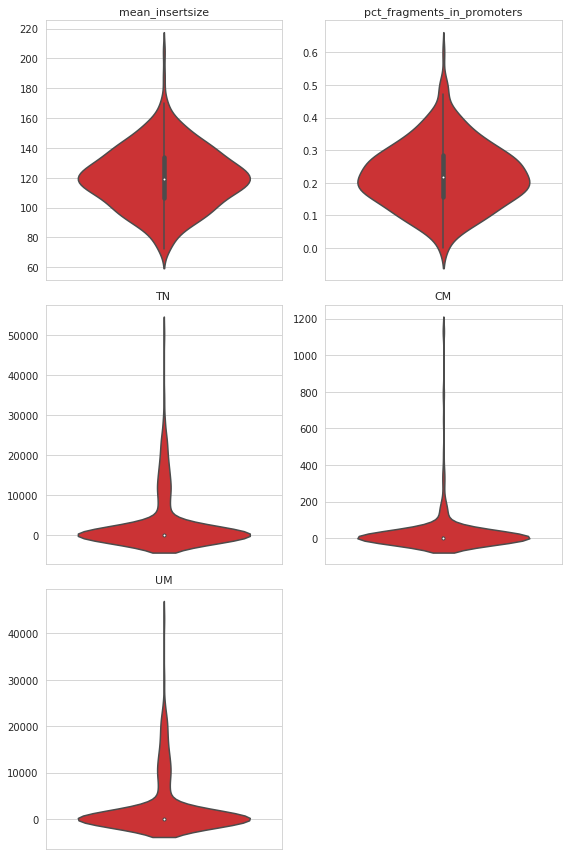

In [17]:
quality_violin(adata, plot_cols)

## 6. filter cells

### 6.1 get tresholds dict

In [18]:
thresholds = get_thresholds_atac_wrapper(adata, manual_thresholds, automatic_thresholds)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,mean_insertsize,59.117151,181.263780
1,pct_fragments_in_promoters,-0.072069,0.518645
2,TN,1.109599,70.276980
3,CM,-1.455495,2.418943
4,UM,-0.668102,52.675059


### 6.2 plot thresholds

(<Figure size 576x864 with 6 Axes>,
 {'mean_insertsize': {},
  'pct_fragments_in_promoters': {},
  'TN': {},
  'CM': {},
  'UM': {}})

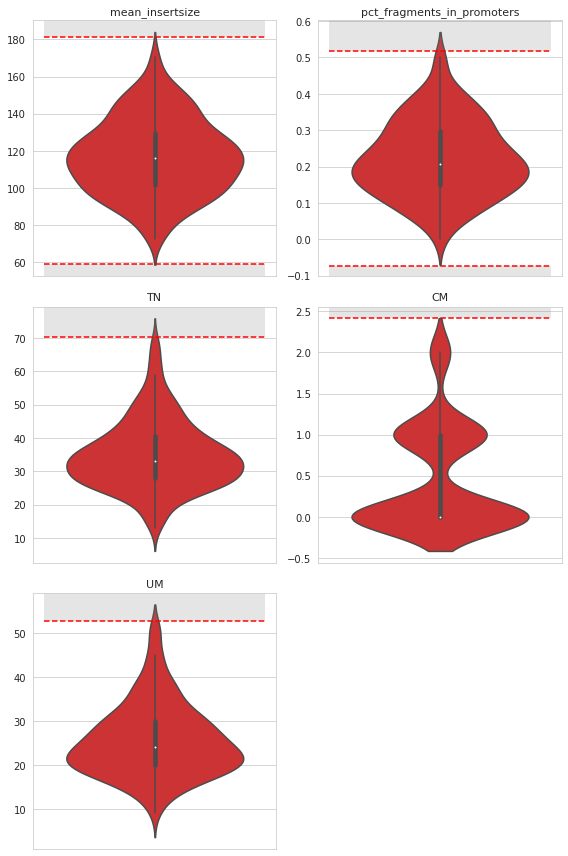

In [22]:
quality_violin(adata, plot_cols, thresholds=thresholds)

### 6.3 filter adata

In [20]:
apply_qc_thresholds(adata, thresholds)

Filtering based on 'mean_insertsize' from 322 -> 320 cells
Filtering based on 'pct_fragments_in_promoters' from 320 -> 319 cells
Filtering based on 'TN' from 319 -> 246 cells
Filtering based on 'CM' from 246 -> 244 cells
Filtering based on 'UM' from 244 -> 243 cells


## 7. save plots

In [21]:
plot_dir = tree.qc_plots
# implement save plots //plot functions have to be modified 

## 8. save adata

In [22]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)